In [1]:
import zipfile
import os

def unzip_file(zip_file_path, extract_to_path):
  """Unzips a zip file to a specified directory.

  Args:
    zip_file_path: The path to the zip file.
    extract_to_path: The directory to extract the contents to.
  """

  try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(extract_to_path)
    print(f"File '{zip_file_path}' unzipped successfully to '{extract_to_path}'.")
  except FileNotFoundError:
    print(f"Error: Zip file '{zip_file_path}' not found.")
  except zipfile.BadZipFile:
    print(f"Error: '{zip_file_path}' is not a valid zip file.")
  except Exception as e:
    print(f"An unexpected error occurred: {e}")

zip_file_path = "/content/CNN_dataset.zip"
extract_to_path = "/content"

os.makedirs(extract_to_path, exist_ok=True)

unzip_file(zip_file_path, extract_to_path)

File '/content/CNN_dataset.zip' unzipped successfully to '/content'.


In [17]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

# Define the dataset path
dataset_path = '/content/CNN_dataset'

# Count images in each category
categories = os.listdir(dataset_path)
for category in categories:
    category_path = os.path.join(dataset_path, category)
    num_images = len(os.listdir(category_path))
    print(f"Category: {category}, Number of Images: {num_images}")

Category: HeadCT, Number of Images: 8000
Category: CXR, Number of Images: 8000
Category: ChestCT, Number of Images: 8000
Category: Hand, Number of Images: 8000
Category: AbdomenCT, Number of Images: 8000


In [30]:
data_gen = ImageDataGenerator(
    rescale=1./255,               # Normalize pixel values
    validation_split=0.2          # Reserve 20% for validation
)

# Create training and validation datasets
train_data = data_gen.flow_from_directory(
    dataset_path,
    target_size=(128, 128),       # Resize images to 128x128
    batch_size=32,               # Set batch size
    class_mode='categorical',    # Multi-class classification
    subset='training'            # Training data
)

val_data = data_gen.flow_from_directory(
    dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 32000 images belonging to 5 classes.
Found 8000 images belonging to 5 classes.


In [6]:
from sklearn.model_selection import train_test_split

dataset_dir = '/content/CNN_dataset'

test_dir = '/content/test'

if not os.path.exists(test_dir):
    os.makedirs(test_dir)

for category in os.listdir(dataset_dir):
    category_path = os.path.join(dataset_dir, category)
    test_category_path = os.path.join(test_dir, category)

    if not os.path.exists(test_category_path):
        os.makedirs(test_category_path)


    image_files = [os.path.join(category_path, f) for f in os.listdir(category_path)]

    # Split into train (80%) and test (20%)
    _, test_images = train_test_split(image_files, test_size=0.2, random_state=42)

    for test_image in test_images:
        shutil.move(test_image, test_category_path)

total_images = sum([len(os.listdir(os.path.join(dataset_dir, category))) for category in os.listdir(dataset_dir)])


In [19]:
# Analyze class distribution
train_class_counts = np.sum(train_data.classes)
val_class_counts = np.sum(val_data.classes)

print(f"Training Class Distribution: {train_class_counts}")
print(f"Validation Class Distribution: {val_class_counts}")


Training Class Distribution: 64000
Validation Class Distribution: 16000


In [20]:
# Build a Sequential CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Prevent overfitting
    Dense(5, activation='softmax')  # Output layer with 5 categories
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       7,372,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,392,965 (28.20 MB)

 Trainable params: 7,392,965 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# prompt: train the model

# Train the model
history = model.fit(
    train_data,
    epochs=5,  # Adjust the number of epochs as needed
    validation_data=val_data
)

Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 928s 928ms/step - accuracy: 0.9709 - loss: 0.0938 - val_accuracy: 0.9950 - val_loss: 0.0209
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 883s 883ms/step - accuracy: 0.9938 - loss: 0.0226 - val_accuracy: 0.9977 - val_loss: 0.0052
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 874s 874ms/step - accuracy: 0.9973 - loss: 0.0102 - val_accuracy: 0.9979 - val_loss: 0.0078
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 894s 894ms/step - accuracy: 0.9960 - loss: 0.0151 - val_accuracy: 0.9955 - val_loss: 0.0169
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 879s 852ms/step - accuracy: 0.9967 - loss: 0.0118 - val_accuracy: 0.9977 - val_loss: 0.0105


In [23]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 65s 261ms/step - accuracy: 0.9970 - loss: 0.0128
Validation Loss: 0.010495806112885475
Validation Accuracy: 0.9977499842643738


In [24]:
test_data_gen = ImageDataGenerator(rescale=1./255)

test_data = test_data_gen.flow_from_directory(
    '/content/test',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_loss, test_accuracy = model.evaluate(test_data)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Found 10000 images belonging to 5 classes.
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 262ms/step - accuracy: 0.9988 - loss: 0.0065
Test Loss: 0.005408297758549452
Test Accuracy: 0.9984999895095825


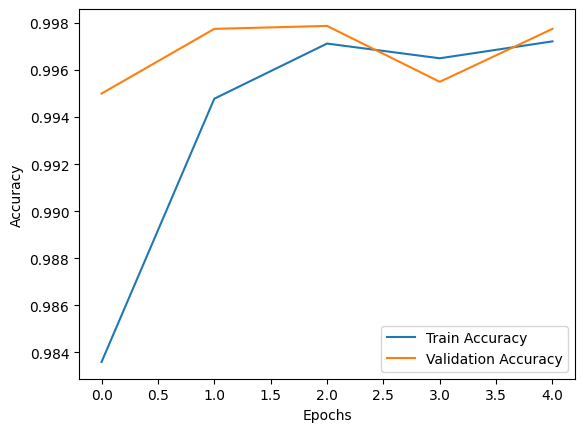

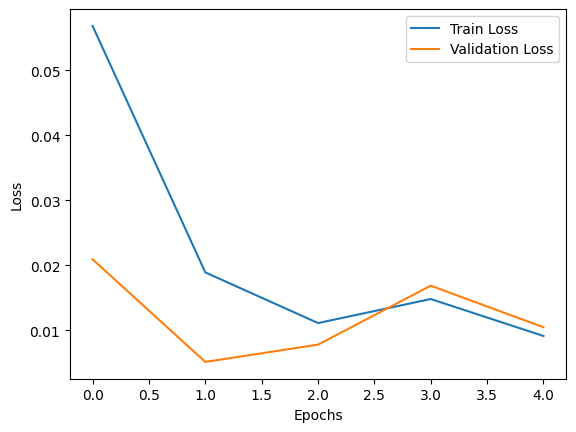

In [25]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


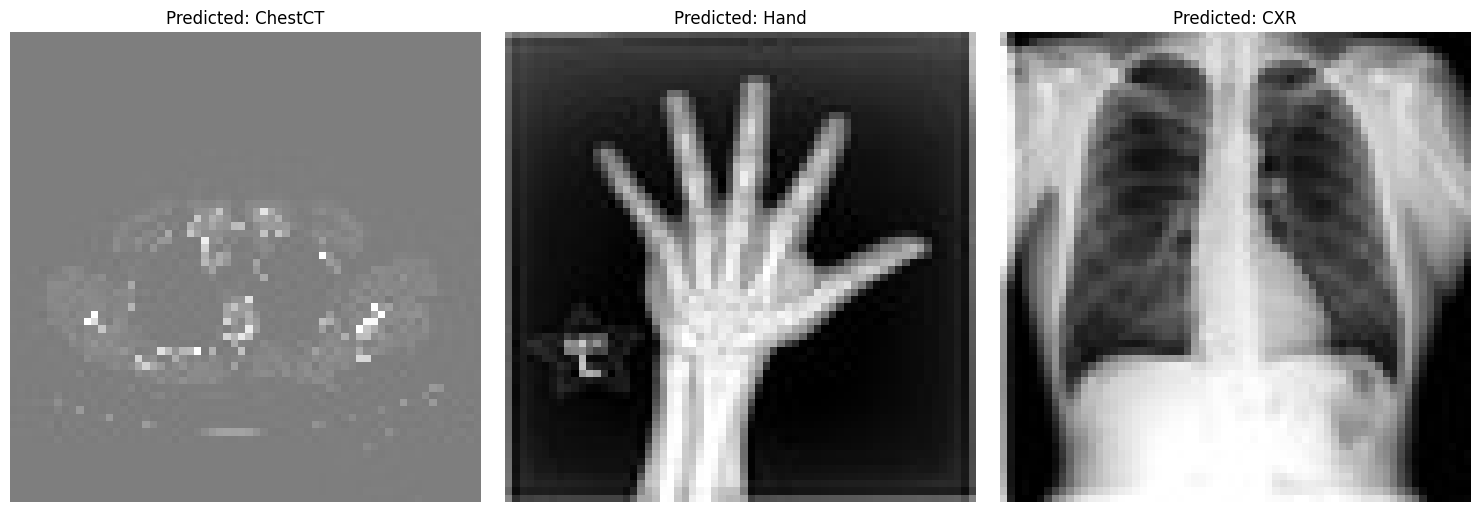

In [36]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

image_paths = [
    '/content/CNN_dataset/ChestCT/000050.jpeg',
    '/content/CNN_dataset/Hand/000052.jpeg',
    '/content/CNN_dataset/CXR/000053.jpeg',
]

class_names = list(train_data.class_indices.keys())
plt.figure(figsize=(15, 10))

for i, img_path in enumerate(image_paths):
    # Check if file exists
    if not os.path.exists(img_path):
        print(f"Error: File not found: {img_path}")
        continue  # Skip to the next image

    img = load_img(img_path, target_size=(128, 128))

    img_array = img_to_array(img) / 255.0

    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class_name = class_names[predicted_class_index]

    plt.subplot(2, 3, i + 1)
    plt.imshow(load_img(img_path))
    plt.title(f"Predicted: {predicted_class_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


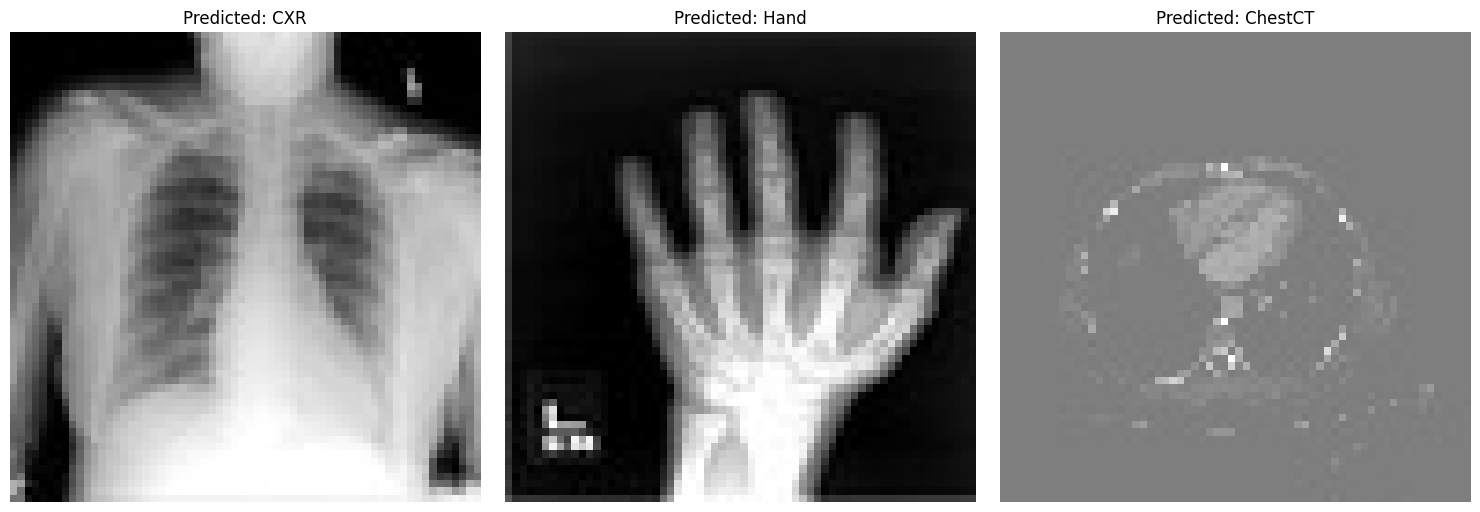

In [38]:
from tensorflow.keras.utils import load_img, img_to_array # you already imported these
from tensorflow.keras.preprocessing import image # this is the line you were missing!


image_paths = [
    '/content/test/CXR/000002.jpeg',
    '/content/test/Hand/000002.jpeg',
    '/content/test/ChestCT/000104.jpeg',
]

class_names = list(train_data.class_indices.keys())
plt.figure(figsize=(15, 10))

for i, img_path in enumerate(image_paths):

    img = image.load_img(img_path, target_size=(128, 128)) #Now this works!


    img_array = image.img_to_array(img) / 255.0 # and this as well!


    img_array = np.expand_dims(img_array, axis=0)


    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class_name = class_names[predicted_class_index]


    plt.subplot(2, 3, i + 1)
    plt.imshow(image.load_img(img_path))
    plt.title(f"Predicted: {predicted_class_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()